In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python3)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/dago/anaconda3/bin/python3 (found version "3.7.6") 
-- Found PythonLibs: /home/dago/anaconda3/lib/libpython3.7m.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/dago/Desktop/Facultad/MN/MNTp3/tp3
-- Configuring done
-- Generating d

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python3 --version
import metnum


/home/dago/Desktop/Facultad/MN/MNTp3/tp3/notebooks
Python 3.7.6


In [3]:
df = pd.read_csv('../data/train.csv')

In [4]:
df = df[df['ciudad']=='Mérida'].dropna()

In [5]:
x = df['metroscubiertos'].values

In [6]:
y = df['precio'].values

In [7]:
x = x.reshape(len(x),1)
y = y.reshape(len(y),1)

In [8]:
x.shape

(518, 1)

In [9]:
from sklearn.linear_model import LinearRegression

"""
Reemplazar por nuestra implementación 
"""

linear_regressor = LinearRegression()
linear_regressor2 = metnum.LinearRegression()

linear_regressor.fit(x,y)
linear_regressor2.fit(x,y)

In [10]:
df['prediction'] = linear_regressor.predict(x)
df['prediction2'] = linear_regressor2.predict(x)

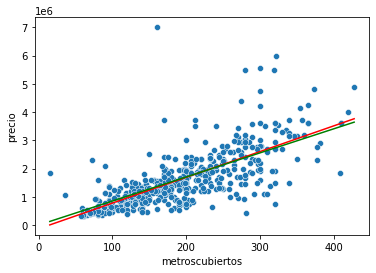

In [11]:
sns.scatterplot(data=df, x='metroscubiertos', y='precio')
sns.lineplot(data=df, x='metroscubiertos', y='prediction', color='red')
sns.lineplot(data=df, x='metroscubiertos', y='prediction2', color='green')


# KFold


In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

def K_Fold(X, y, K=10):
    
    kfold = KFold(n_splits=K)
    #kfold.get_n_splits(X)
    rmse = []
    rmsle = []
    
    for train_index, test_index in kfold.split(X):
        # Separamos el conjunto de entrenamiento y el conjunto de test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        linear_regressor = metnum.LinearRegression()
        linear_regressor.fit(X_train, y_train) 
        y_pred = linear_regressor.predict(X_test)
        
        if not (y_pred < 0).any():
            rmsle.append(mean_squared_log_error(y_test, y_pred))
        rmse.append(mean_squared_error(y_test, y_pred, squared=False))
        
        
    return np.mean(rmse), np.mean(rmsle)

In [5]:
df = pd.read_csv('../data/train.csv')
df = df[df['ciudad']=='Mérida'].dropna()
x = df['metroscubiertos'].values
y = df['precio'].values
x = x.reshape(len(x),1)
y = y.reshape(len(y),1)
rmse, rmsle = K_Fold(x, y, 10) # 10% de las muestras para testear
print(rmse, rmsle)

644839.3753734664 0.16553826516219017


# Experimentación


- Revisar las columnas y el precio, ver si encontramos alguna relacion con un primer approach naive.
- Definir la expirementacion :D


- Definir un nuevo feature que sea zona urbana/zona rural por que pueden tener comportamientos distintos


In [6]:
def fecha_parser(df):
    df['fecha'] = (pd.to_datetime(df['fecha']) - pd.to_datetime(df['fecha'].min())).dt.days

def complete_metrostotales(df):
    df['metrostotales'] = df['metrostotales'].fillna(df['metroscubiertos'])
    
def fill_banosterrenos(df):
    df['banos'] = df.apply(
        lambda row: 0 if row['tipodepropiedad']=='Terreno' and np.isnan(row['banos']) else row['banos'],
        axis=1
    )
    df['banos'] = df.apply(
        lambda row: 0 if row['tipodepropiedad']=='Terreno comercial' and np.isnan(row['banos']) else row['banos'],
        axis=1
    )

def poblacion():
    df = pd.read_csv('../data/poblacion.csv', names=['poblacion', 'ciudad'])
    return df
    
def get_data(filename='../data/train.csv'):
    df = pd.read_csv(filename)
    fecha_parser(df)
    complete_metrostotales(df)
    fill_banosterrenos(df)
    df = df[(df['lat'] > 13) & (df['lat'] < 34) & (df['lng'] >= -117) & (df['lng'] <= -87)]
    dfPob = poblacion()
    dfJoin = pd.merge(df, dfPob, how='left')
    return dfJoin


In [7]:
def plot_prediction(df, columns, column_to_show='metrostotales', column_to_predict='precio', kfold_flag=False):
    df = df.reindex(columns=(columns+[column_to_predict])).dropna()
    y = df[column_to_predict].values
    df = df.drop(columns=[column_to_predict])
    X = df.to_numpy()
    print('Size: ', X.shape[0])
    #from sklearn.linear_model import LinearRegression


    #linear_regressor = LinearRegression()
    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(X,y)

    df['prediction'] = linear_regressor.predict(X)
    
    print(list(zip(df.columns, linear_regressor.coef())))

    print((df['prediction'] < 0).any())
    
    #plt.scatter(df[column_to_show], y, edgecolors='white', linewidths=1.0)
    #plt.plot(df[column_to_show], df['prediction'], label=f'predicción de {column_to_show}', color='red')
    #plt.xlabel("alpha")
    #plt.ylabel('k',rotation=0)
    #plt.legend()
    #plt.title('title')
    #plt.show()
    
    sns.scatterplot(x=df[column_to_show], y=y).set_title(f"{column_to_predict} en función de {column_to_show}")
    sns.lineplot(data=df, x=column_to_show, y='prediction', color='red', label=f'predicción de {column_to_predict}')
    
    if (kfold_flag):
        X = X.reshape(len(X),len(columns))
        y = y.reshape(len(y),1)

        rmse, rmsle = K_Fold(X, y, 10) # 10% de las muestras para testear
        print(rmse, '  ', rmsle)

In [62]:
df = pd.read_csv('../data/train.csv')
(pd.to_datetime(df['fecha'].max()) - pd.to_datetime(df['fecha'].min())).days

1826

In [17]:
df = get_data()
print(df[df['tipodepropiedad']=='Edificio']['banos'])
fill_banosterrenos(df)
print(df[df['tipodepropiedad']=='Edificio']['banos'])

242       NaN
510       NaN
1228      NaN
1684      NaN
3029      NaN
         ... 
238459    NaN
238890    NaN
238933    2.0
238982    NaN
239142    4.0
Name: banos, Length: 774, dtype: float64
242       NaN
510       NaN
1228      NaN
1684      NaN
3029      NaN
         ... 
238459    NaN
238890    NaN
238933    2.0
238982    NaN
239142    4.0
Name: banos, Length: 774, dtype: float64


### Lista total

In [19]:
df['banos'].value_counts()

2.0    87683
1.0    58173
3.0    49365
4.0    18558
Name: banos, dtype: int64

# Como primera experimentacion vamos a probar con todas las features, y sin segmentar para ver si obtenemos resultados. Y dropear los que tengas columnas incompletas

Nos da negativo si ponemos muchas features. WHY?


True


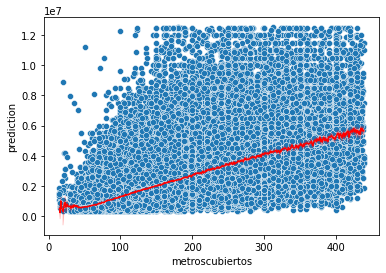

In [20]:
df = pd.read_csv('../data/train.csv')
df2 = df.reindex(columns=["metroscubiertos", "metrostotales", "habitaciones", "banos","antiguedad", "precio"]).dropna()
#df2 = df2[(df2['lat'] > 13) & (df2['lat'] < 34) & (df2['lng'] >= -117) & (df2['lng'] <= -87)]
#df2['lng'] = df2['lng'].abs()

y = df2['precio'].values
df2 = df2.drop(columns=['precio'])
X = df2.to_numpy()

#from sklearn.linear_model import LinearRegression


#linear_regressor = LinearRegression()
linear_regressor = metnum.LinearRegression()
linear_regressor.fit(X,y)

df2['prediction'] = linear_regressor.predict(X)

print((df2['prediction'] < 0).any())

sns.scatterplot(x=df2['metroscubiertos'], y=y)
sns.lineplot(data=df2, x='metroscubiertos', y='prediction', color='red')

#sns.scatterplot(x=df2['antiguedad'], y=y)
#sns.lineplot(data=df2, x='antiguedad', y='prediction', color='red')

In [24]:
list(zip(df2.columns, linear_regressor.coef()))

[('metroscubiertos', array([10038.37234493])),
 ('metrostotales', array([2823.74695962])),
 ('habitaciones', array([-355666.59012985])),
 ('banos', array([478829.67201005])),
 ('antiguedad', array([14440.92932132]))]

In [22]:
pd.options.display.max_rows = 100
df2['metroscubiertosporhabitacion'] = df2['metroscubiertos'] / (df2['habitaciones']+df['banos'])
print(df2[df2['prediction'] < 0]['metroscubiertosporhabitacion'].min())
df2[df2['prediction'] < 0]



1.8181818181818181


,metroscubiertos,metrostotales,habitaciones,banos,antiguedad,prediction,metroscubiertosporhabitacion
3464,120.0,200.0,9.0,2.0,19.0,-1.996082e+05,10.909091
19278,65.0,65.0,4.0,1.0,5.0,-3.559429e+04,13.000000
21680,90.0,100.0,10.0,1.0,10.0,-1.747599e+06,8.181818
30951,110.0,110.0,10.0,1.0,5.0,-1.590798e+06,10.000000
38060,160.0,160.0,10.0,2.0,5.0,-4.688628e+05,13.333333
43392,66.0,50.0,4.0,1.0,1.0,-1.256758e+05,13.200000
43713,65.0,65.0,4.0,1.0,5.0,-3.559429e+04,13.000000
45474,16.0,16.0,3.0,1.0,10.0,-2.379669e+05,4.000000
46312,56.0,56.0,4.0,1.0,5.0,-1.513534e+05,11.200000
47645,109.0,109.0,7.0,2.0,0.0,-1.300358e+05,12.111111


In [ ]:
df2['habitaciones'].value_counts()

Primero hicimos la exprimentación con metros cubiertos, metros totales, habitaciones, baños y antiguedad para obtener un resultado general sin hacer una segmentación previa. En los resultados obtenidos, observamos que varios predicciones resultaron negativas entonces decidimos analizar esos resultados negativos. Los coeficientes obtenidos negativos fueron: 
 ('metroscubiertos', 10310.037575517254),
 ('metrostotales', 2615.496771363549),
 ('habitaciones', -420750.47429835715),
 ('banos', 457367.5660298784),
 ('antiguedad', 13674.213724549987)
Lo cual nos hizo pensar que la cantidad de habitaciones era mayor que en el promedio de las propiedades en venta por sobre la cantidad de metros totales/cubiertos. Para verificar esto calculamos metros cubiertos / (habitaciones + banos) pero los valores obtenidos no se diferenciaban de los que que si tenian un valor positivo(o al menos 11k tenian valores similares).
Seguimos analizando y notamos que los baños y habitaciones parecen tener coeficientes que se relacionan de forma inversa.

In [25]:
# cuantas propiedades cumplen cosas parecidas a las malas(las que la prediccion da negativa)
pd.options.display.max_rows = 100
df2['banosporhabitacion'] = df2['banos'] / df2['habitaciones']
# df2[df2['prediccion' < 0].max(banosporhabit) = 0.571429
df2[df2['banosporhabitacion'] < 0.571429]

,metroscubiertos,metrostotales,habitaciones,banos,antiguedad,prediction,metroscubiertosporhabitacion,banosporhabitacion
3,63.0,67.0,2.0,1.0,1.0,6.035459e+05,21.000000,0.500000
4,95.0,95.0,2.0,1.0,10.0,1.133807e+06,31.666667,0.500000
5,75.0,90.0,2.0,1.0,5.0,8.467163e+05,25.000000,0.500000
22,179.0,224.0,4.0,1.0,0.0,1.485551e+06,35.800000,0.250000
26,40.0,66.0,2.0,1.0,3.0,3.987215e+05,13.333333,0.500000
...,...,...,...,...,...,...,...,...
239981,50.0,65.0,2.0,1.0,10.0,5.973680e+05,16.666667,0.500000
239984,62.0,65.0,2.0,1.0,20.0,8.622377e+05,20.666667,0.500000
239987,83.0,90.0,3.0,1.0,0.0,4.991520e+05,20.750000,0.333333
239990,118.0,124.0,3.0,1.0,20.0,1.235321e+06,29.500000,0.333333


(array([   35.,   910., 15128., 25651., 21963., 18056., 15808., 10573.,
         8860.,  5583.,  4944.,  2408.,  1779.,  1185.,   590.,   112.,
           79.,    57.,    47.,    57.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200.]),
 <a list of 20 Patch objects>)

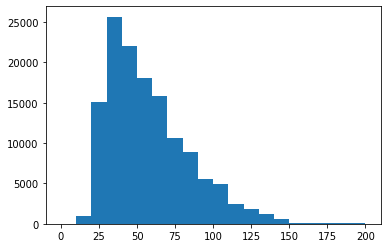

In [26]:
plt.hist(df2['metroscubiertos'] / df2['habitaciones'], range=[0,200], bins=20)

# exp para determinar si estan mal clasificados las lng y lat

In [27]:
print(len(df2))
print(len(df2[(df2['lat'] > 13) & (df2['lat'] < 34)]))

print(len(df2))
print(len(df2[(df2['lng'] >= -117) & (df2['lng'] <= -87)]))

133942


KeyError: 'lat'

In [28]:
print(len(df2[df2['lat'] < 0]))

KeyError: 'lat'

In [ ]:
df = pd.read_csv('../data/train.csv')
df2 = df.reindex(columns=["antiguedad", "habitaciones", "garages", "banos", "metroscubiertos", "metrostotales", "lat",
                          "lng", "gimnasio", "usosmultiples", "piscina", "escuelascercanas", "centroscomercialescercanos", "precio"]).dropna()
df2 = df2[(df2['lat'] > 13) & (df2['lat'] < 34) & (df2['lng'] >= -117) & (df2['lng'] <= -87)]
df2['lng'] = df2['lng'].abs()

y = df2['precio'].values
df2 = df2.drop(columns=['precio'])
X = df2.to_numpy()

print(K_Fold(X, y, 10))

##LATEX

En base a los resultados previos podemos preveer que para distintos tipos de propiedades(comerciales/residenciales/hoteleria) la relación entre los distintos $features$ puede ser muy distinta por lo que nos interesa separar estas categorias. Por ejemplo la cantidad de baños en relacion con la cantidad de habitaciones es diferente en un hostel que en una oficina que en una casa.

- mejorar la relacion para algun feature preexistente de forma no lineal(por ejemplo agregando nuevos features que sean funciones de los inciales baños ** 2)
- 

# Observaciones:
- Podemos elimnar las latitudes que esten fuera de las latitudes de mexico y lo mismo para lng
- Hacemos modulo de la latitud y longitud para poder usar rmsle (eliminamos aprox 1k de lng mal tageados)
El data set est

# Preguntas:
Como ir viendo los graficos si se experimenta con KFold y esto genera K distintos


In [29]:
df = get_data()
df.isna().sum()

id                                0
titulo                         1048
descripcion                     591
tipodepropiedad                  15
direccion                     23499
ciudad                          153
provincia                        37
antiguedad                    19069
habitaciones                  10920
garages                       17964
banos                          6921
metroscubiertos                8455
metrostotales                     0
idzona                        10698
lat                               0
lng                               0
fecha                             0
gimnasio                          0
usosmultiples                     0
piscina                           0
escuelascercanas                  0
centroscomercialescercanos        0
precio                            0
dtype: int64

Vemos que hay muchas columnas que nos interesan que tienen muchos valores en Null.
Nos llama la atención la dif de valores null entre metros cubiertos y totales, vamos a ver si observando en que tipos de propiedades están los valores null de metros totales podemos llegar a una conclusión de que esta pasando.

In [30]:
df = get_data()
df[df['metrostotales'].isna()]['tipodepropiedad'].value_counts()

Series([], Name: tipodepropiedad, dtype: int64)

## Decisión metros totales
Como hay muchos casos en donde no hay metros totales pero posiblemente si hay mtrs cubiertos (mayormente apartamentos en donde tien sentido que todos los metros cubiertos sean los totales), para los casos en donde metros totales es null decidimos completarlos con los metros cubiertos.
Opcional:podríamos realizar una segmentación entre propiedades en donde importan los metros cubiertos vs totales (por ejemplo los terrenos y metros cubiertos=nan)

In [31]:
df = get_data()
df[df['banos'].isna()]['tipodepropiedad'].value_counts()

Casa                             3491
Local Comercial                   933
Edificio                          557
Apartamento                       544
Oficina comercial                 389
Casa en condominio                360
Bodega comercial                  264
Casa uso de suelo                  89
Inmuebles productivos urbanos      72
Local en centro comercial          63
Otros                              56
Quinta Vacacional                  23
Villa                              20
Terreno industrial                 17
Nave industrial                    17
Rancho                             10
Huerta                              3
Duplex                              3
Departamento Compartido             2
Name: tipodepropiedad, dtype: int64

In [32]:
df = get_data()
columns=["metroscubiertos", "metrostotales", "habitaciones", "banos","antiguedad"]
plot_prediction(df, columns, kfold_flag=True)

NameError: name 'plot_prediction' is not defined

# tamos trabados so segmentation time


- Division por tipo de propiedad entre comercial y residencial(y rural?) teniendo en cuenta tipo de mercado
- - Comercial: 
- - - Local Comercial
- - - Oficina comercial
- - - Bodega comercial 
- - - Terreno comercial
- - - Local en centro comercial
- - - Inmuebles productivos urbanos
- - - 
- - - Nave industrial                      
- - - Terreno industrial
- - - Hospedaje  
-------
------
- - Residencial
- - - Casa 
- - - Apartamento
- - - Casa en condominio
- - - Terreno
- - - Edificio
- - - Casa uso de suelo
- - - Quinta Vacacional
- - - Duplex
- - - Villa 
- - -
- - - Rancho
- - - Departamento Compartido
- - - 
- Por lapsos de años teniendo en cuenta el crecimiento/ fluctuacion del mercado inmobiliario / inflacion


# Segmentacion de df en comercial y residencial

In [ ]:
df = pd.read_csv('../data/train.csv')

dfComercial = df[df['tipodepropiedad'].isin(['Local Comercial', 'Oficina comercial', 'Bodega comercial', 'Terreno comercial', 'Local en centro comercial', 'Inmuebles productivos urbanos', 'Nave industrial','Terreno industrial', 'Hospedaje'])]
dfResidencial = df[df['tipodepropiedad'].isin(['Casa', 'Apartamento', 'Casa en condominio', 'Terreno', 'Edificio', 'Casa uso de suelo', 'Quinta Vacacional', 'Duplex', 'Villa'])]
dfResidencial

In [49]:
df = pd.read_csv('../data/train.csv')
df['ciudad'].value_counts().nlargest(100)

Querétaro                      12646
Benito Juárez                  11014
Zapopan                        10360
San Luis Potosí                 7925
Mérida                          7162
Monterrey                       6946
Alvaro Obregón                  6633
Cuauhtémoc                      6614
Naucalpan de Juárez             6554
Miguel Hidalgo                  5795
Atizapán de Zaragoza            5783
Tlalpan                         5721
Huixquilucan                    5718
Coyoacán                        5293
Puebla                          4636
Guadalajara                     4006
San Andrés Cholula              3805
Cancún                          3779
Cuernavaca                      3775
Chihuahua                       3757
Tlalnepantla de Baz             3588
Cuautitlán Izcalli              3408
Tlajomulco de Zúñiga            3254
Gustavo A. Madero               3141
Iztapalapa                      3093
Cuajimalpa de Morelos           3020
Tijuana                         2863
H

Size:  85028
[('metroscubiertos', array([9438.0633088])), ('metrostotales', array([3446.49143382])), ('habitaciones', array([-387751.2089851])), ('banos', array([606883.41941654])), ('antiguedad', array([12789.65897557]))]
True


/home/dago/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dago/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1480079.2981046743    nan


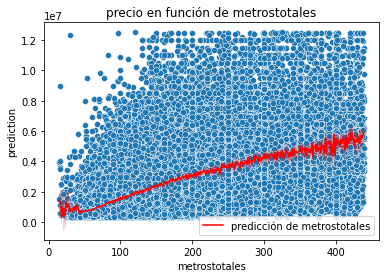

In [46]:
df = get_data()
columns=["metroscubiertos", "metrostotales", "habitaciones", "banos","antiguedad"]
plot_prediction(df, columns, kfold_flag=True)

Size:  414
[('metroscubiertos', array([4680.40058967])), ('metrostotales', array([2067.89582469])), ('habitaciones', array([110182.2785288])), ('banos', array([460735.48340701])), ('antiguedad', array([8442.11763672]))]
False
1780433.0086265448    0.42641998284568894


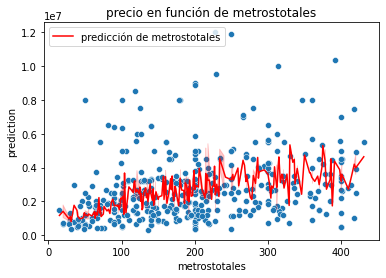

In [47]:
df = get_data()
dfComercial = df[df['tipodepropiedad'].isin(['Local Comercial', 'Oficina comercial', 'Bodega comercial', 'Terreno comercial', 'Local en centro comercial', 'Inmuebles productivos urbanos', 'Nave industrial','Terreno industrial', 'Hospedaje'])]
columns=["metroscubiertos", "metrostotales", "habitaciones", "banos","antiguedad"]
plot_prediction(dfComercial, columns, kfold_flag=True)


Las métricas nos están dando feo, tal vez es porque estamos usando poca data ? => vamos a analizar de a una feature y ver que sucede

Size:  3435
[('metroscubiertos', array([12817.1778242]))]
False
2167009.952878393    0.6618820806334929


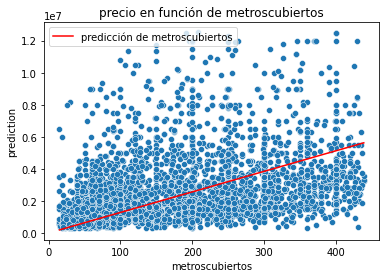

In [48]:
df = get_data()
dfComercial = df[df['tipodepropiedad'].isin(['Local Comercial', 'Oficina comercial', 'Bodega comercial', 'Terreno comercial', 'Local en centro comercial', 'Inmuebles productivos urbanos', 'Nave industrial','Terreno industrial', 'Hospedaje'])]
columns=["metroscubiertos"] #, "metrostotales", "habitaciones", "banos","antiguedad"]
plot_prediction(dfComercial, columns, column_to_show='metroscubiertos', kfold_flag=True)

Size:  104608
[('metroscubiertos', array([14361.09397577]))]
False
1625713.3998771629    0.3572406861677924


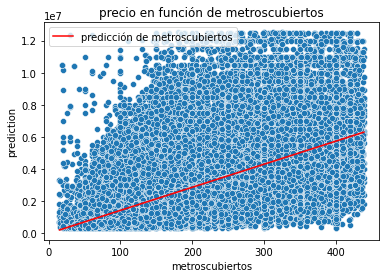

In [49]:
df = get_data()
columns=["metroscubiertos"]#, "metrostotales", "habitaciones", "banos","antiguedad"]
dfResidencial = df[df['tipodepropiedad'].isin(['Casa', 'Apartamento', 'Casa en condominio', 'Terreno', 'Edificio', 'Casa uso de suelo', 'Quinta Vacacional', 'Duplex', 'Villa'])]
plot_prediction(dfResidencial, columns, column_to_show='metroscubiertos', kfold_flag=True)

In [ ]:
y = df2['precio']
x = df2.drop(columns=['precio'])
x = x.values
y = y.values
x = x.reshape(len(x),5)
y = y.reshape(len(y),1)

rmse, rmsle = K_Fold(x, y, 10) # 10% de las muestras para testear
print(rmse, '  ', rmsle)

In [ ]:
df['tipodepropiedad'].value_counts()

In [ ]:
df[df['tipodepropiedad']=='Edificio']

In [ ]:
pd.to_datetime(df['fecha'])

df.groupby([pd.to_datetime(df['fecha']).dt.year]).count()


Vamos a realizar el mismo experimento que antes pero antes segmentando por casas para ver si cambia

In [ ]:
df = pd.read_csv('../data/train.csv')
df = df[df['tipodepropiedad'] == 'Villa']
df2 = df.reindex(columns=["metroscubiertos", "metrostotales", "habitaciones", "banos","antiguedad", "precio"]).dropna()
#df2 = df2[(df2['lat'] > 13) & (df2['lat'] < 34) & (df2['lng'] >= -117) & (df2['lng'] <= -87)]
#df2['lng'] = df2['lng'].abs()

y = df2['precio'].values
df2 = df2.drop(columns=['precio'])
X = df2.to_numpy()

#from sklearn.linear_model import LinearRegression


#linear_regressor = LinearRegression()
linear_regressor = metnum.LinearRegression()
linear_regressor.fit(X,y)

df2['prediction'] = linear_regressor.predict(X)

print((df2['prediction'] < 0).any())

sns.scatterplot(x=df2['metrostotales'], y=y)
sns.lineplot(data=df2, x='metrostotales', y='prediction', color='red')

#sns.scatterplot(x=df2['antiguedad'], y=y)
#sns.lineplot(data=df2, x='antiguedad', y='prediction', color='red')

# Poblacion

In [5]:
df = get_data()

In [38]:
df[df['poblacion'].isna()]['ciudad'].value_counts().nlargest(50)

Solidaridad                    131
Chalco                         118
Xochitepec                     115
Cajeme                         112
San Mateo Atenco               109
Atlatlahucan                   109
Tultepec                       104
Huehuetoca                      99
Valle de Bravo                  92
Medellín                        91
García                          90
Zumpango                        89
Calimaya                        85
Tizayuca                        84
Altamira                        82
Chapala                         81
Campeche                        77
Progreso                        76
Comalcalco                      71
Tepotzotlán                     68
Zinacantepec                    66
Apizaco                         64
Santa María Huatulco            64
Ahome                           60
Texcoco                         58
Conkal                          55
Carmen                          52
Ocoyoacac                       51
Atlixco             

# Tipos de ciudades por población
    - Mexico city > 8M
    - Grande: 400k - 
    - Media: 200k - 400k
    - Chica: 0 - 200k

In [6]:
dfMexicoCity = df[df['poblacion'] >= 8000000]
len(dfMexicoCity)

29791

In [7]:
dfMetropolis = df[df['poblacion'] < 8000000]
dfMetropolis = dfMetropolis[dfMetropolis['poblacion'] >= 1000000]
len(dfMetropolis)

17026

In [8]:
dfBigCity = df[df['poblacion'] < 1000000]
dfBigCity = dfBigCity[dfBigCity['poblacion'] >= 650000]
len(dfBigCity)

27580

In [9]:
dfMediumCity = df[df['poblacion'] < 650000]
dfMediumCity = dfMediumCity[dfMediumCity['poblacion'] >= 250000]
len(dfMediumCity)

18004

In [10]:
dfSmallCity = df[df['poblacion'] < 250000]
len(dfSmallCity)

19220

Size:  23733
[('metroscubiertos', array([9145.92855244])), ('metrostotales', array([7996.36454364])), ('habitaciones', array([-523977.80518974])), ('banos', array([714554.01753097])), ('antiguedad', array([-20322.22376332])), ('poblacion', array([0.09538139]))]
True
1607966.0239981401    0.23983146519696918


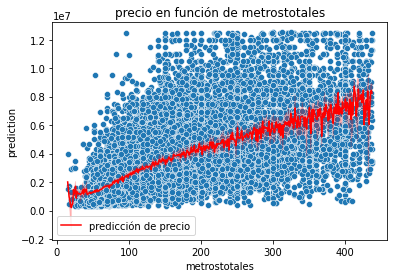

In [19]:
columns=["metroscubiertos", "metrostotales", "habitaciones", "banos", "antiguedad", "poblacion"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True)

Size:  12106
[('metroscubiertos', array([6665.46285963])), ('metrostotales', array([7238.21907445])), ('habitaciones', array([-213708.64749123])), ('banos', array([420839.76360222])), ('antiguedad', array([-18047.74631014])), ('poblacion', array([-0.20589429]))]
True


/home/dago/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dago/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


990195.9892212108    nan


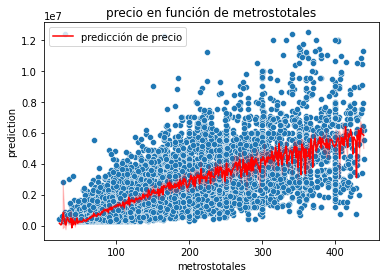

In [20]:
columns=["metroscubiertos", "metrostotales", "habitaciones", "banos", "antiguedad", "poblacion"]
plot_prediction(dfMetropolis, columns, kfold_flag=True)

Size:  18576
[('metroscubiertos', array([8718.85138832])), ('metrostotales', array([3145.67874318])), ('habitaciones', array([-63209.58514565])), ('banos', array([337942.54223523])), ('antiguedad', array([8715.02757079])), ('poblacion', array([-0.90351987]))]
True
1017399.7683194941    0.19713753110885843


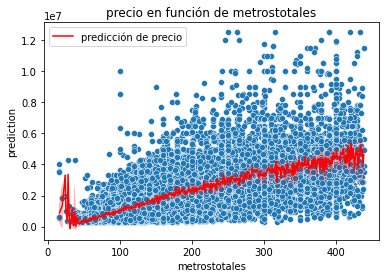

In [21]:
columns=["metroscubiertos", "metrostotales", "habitaciones", "banos", "antiguedad", "poblacion"]
#dfBigCity['espaciopersonal'] = dfBigCity['metroscubiertos'] / dfBigCity['habitaciones']
plot_prediction(dfBigCity, columns, kfold_flag=True)

Size:  13378
[('metroscubiertos', array([8318.04445709])), ('metrostotales', array([4199.59986012])), ('habitaciones', array([-292945.17591971])), ('banos', array([315056.549275])), ('antiguedad', array([-279.21376423])), ('poblacion', array([-0.03935855]))]
True
857179.1143366976    0.2121418903649514


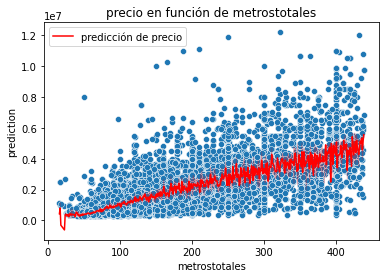

In [22]:
columns=["metroscubiertos", "metrostotales", "habitaciones", "banos", "antiguedad", "poblacion"]
plot_prediction(dfMediumCity, columns, kfold_flag=True)

/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Size:  13567
[('metroscubiertos', array([13647.12036011])), ('metrostotales', array([2605.55364107])), ('habitaciones', array([-922527.59850249])), ('banos', array([481980.74590758])), ('antiguedad', array([8849.58680406])), ('poblacion', array([6.95428058])), ('isVerySmall', array([648541.15569477]))]
True


/home/dago/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dago/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1566597.9931754204    nan


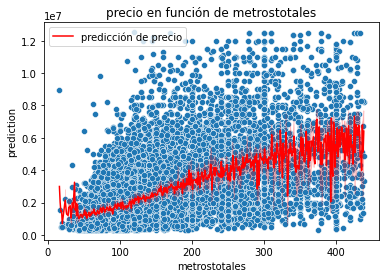

In [23]:
columns=["metroscubiertos", "metrostotales", "habitaciones", "banos", "antiguedad", "poblacion", "isVerySmall"]
dfSmallCity['isVerySmall'] = dfSmallCity['poblacion'] < 150000
plot_prediction(dfSmallCity, columns, kfold_flag=True)

# Refinando resultados obtenidos por cantidad de poblacion para mejorar el error

In [29]:
def add_function_features(df, columns, function, suffix):
    for column in columns:
        df[column+suffix] = df[column].apply(function)

In [51]:
def cuadratic(x):
    return x ** 2

In [52]:
def cubic(x):
    return x ** 3

In [53]:
def forth(x):
    return x ** 4

In [46]:
def sen(x):
    return np.sin(x)

In [60]:
def log(x):
    return np.log2(x + 1)

--------------------------------------------------------------
## dfMexicoCity 

Size:  29791
[('metrostotales', array([20773.04313588]))]
False
1992873.7195064947    0.3031362888480776


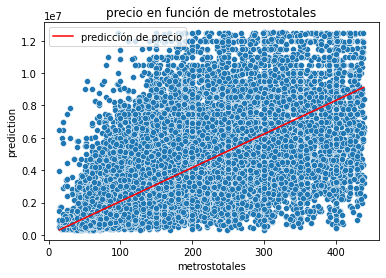

In [31]:
columns=["metrostotales"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True)

/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Size:  29791
[('metrostotales', array([28843.4158591])), ('metrostotales_2', array([-30.45086316]))]
False
1911474.0423559844    0.32468527259984414


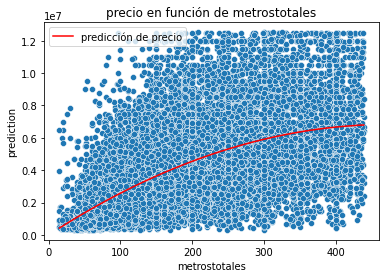

In [36]:
# dfMexicoCity['unos'] = np.ones(len(dfMexicoCity))
add_function_features(dfMexicoCity, ['metrostotales'], cuadratic, '_2')
columns=["metrostotales", "metrostotales_2"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True)

/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Size:  29791
[('metrostotales', array([28286.33784073])), ('metrostotales_2', array([-25.33427388])), ('metrostotales_3', array([-0.00989922]))]
False
1911501.0337364282    0.32292521540467034


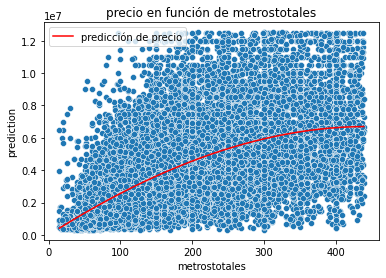

In [38]:
add_function_features(dfMexicoCity, ['metrostotales'], cubic, '_3')
columns=["metrostotales", "metrostotales_2", "metrostotales_3"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True)

/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Size:  29791
[('metrostotales', array([20791.56965708])), ('metrostotales_sen', array([43978.99435424]))]
False
1992739.4685647774    0.30320631828640865


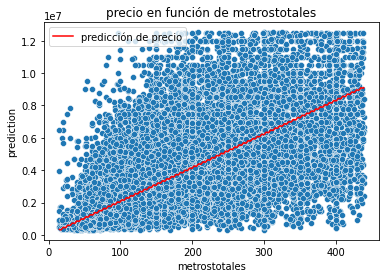

In [50]:
add_function_features(dfMexicoCity, ['metrostotales'], sen, '_sen')
columns=["metrostotales", "metrostotales_sen"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True)

/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Size:  29791
[('metrostotales', array([0.])), ('metrostotales_2', array([380.12185209])), ('metrostotales_3', array([-1.70553998])), ('metrostotales_4', array([0.0021472]))]
False
1930276.5756959456    0.31166222472599986


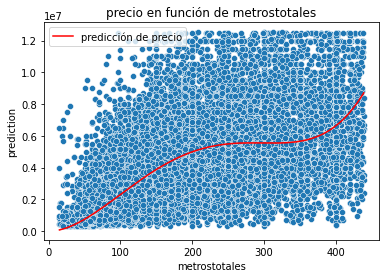

In [55]:
add_function_features(dfMexicoCity, ['metrostotales'], forth, '_4')
columns=["metrostotales", "metrostotales_2", "metrostotales_3", "metrostotales_4"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True)

## metroscubiertos

Size:  28258
[('metroscubiertos', array([19487.50837876]))]
False
1927475.1543434518    0.2889775375575524


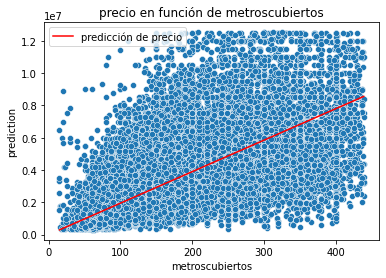

In [57]:
columns=["metroscubiertos"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True, column_to_show='metroscubiertos')

/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Size:  28258
[('metroscubiertos', array([27355.51021712])), ('metroscubiertos_2', array([-28.95686852]))]
False
1853577.0344994222    0.30297366662916236


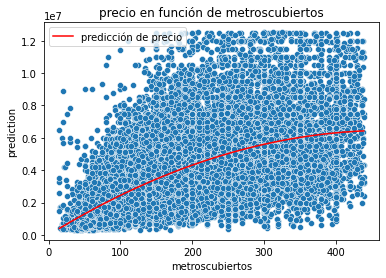

In [56]:
add_function_features(dfMexicoCity, ['metroscubiertos'], cuadratic, '_2')
columns=["metroscubiertos", "metroscubiertos_2"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True, column_to_show='metroscubiertos')

/home/dago/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Size:  28258
[('metroscubiertos', array([29040.51823051])), ('metroscubiertos_2', array([-32.26298216])), ('metroscubiertos_log', array([-22903.85415711]))]
False
1853382.114872276    0.29896220322924244


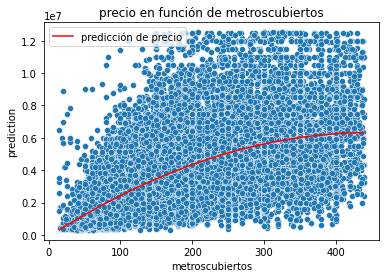

In [62]:
add_function_features(dfMexicoCity, ['metroscubiertos'], log, '_log')
columns=["metroscubiertos", "metroscubiertos_2", "metroscubiertos_log"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True, column_to_show='metroscubiertos')

Size:  23733
[('metrostotales', array([14462.01407721])), ('metrostotales_2', array([-15.48334166])), ('banos', array([615027.1202121])), ('habitaciones', array([-587766.69774485])), ('antiguedad', array([-19951.01475528])), ('poblacion', array([-0.45528658])), ('metroscubiertos', array([-1383.71719435])), ('metroscubiertos_2', array([7.7582204])), ('metroscubiertos_log', array([900121.23626098]))]
True


/home/dago/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/dago/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1589482.5884480046    nan


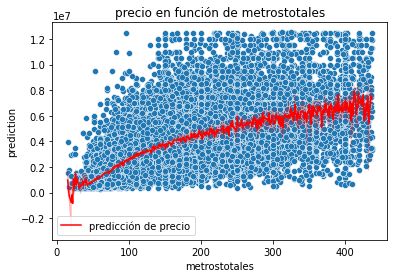

In [63]:
columns=["metrostotales", "metrostotales_2", "banos", "habitaciones", "antiguedad", "poblacion", "metroscubiertos", "metroscubiertos_2", "metroscubiertos_log"]
plot_prediction(dfMexicoCity, columns, kfold_flag=True)